# This is to demo GenAI prompt in FSI

## Financial report auto-tagging

As to factor modeling, some factors are derived from financial report data. It's quite common to fetch values from financial reports. Following is Apple Q1 2021 financial reprot. You may want to get year-over-year revenue growth, iPhone revenue, current cash asset, and return on equity (ROE). 

In order to make reports or documents easier to search or further processing, it's a common need to tag them. You want to tag it by industry, sector, company, etc.
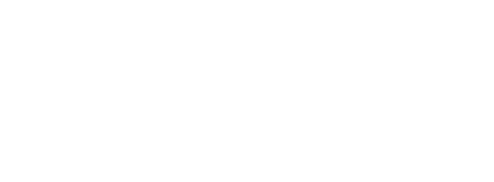
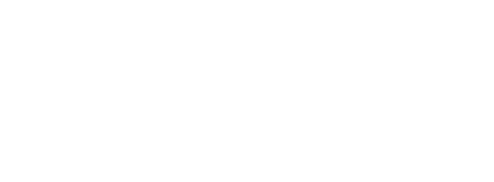
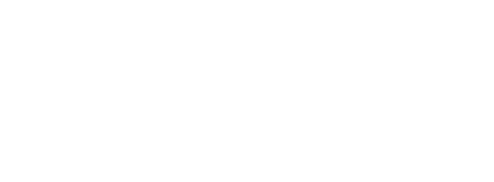

In [28]:
# Please update with your own deployed endpoint name and model name. 
endpoint_name = 'jumpstart-dft-hf-llm-mistral-7b-ins-xxx'
model_name='huggingface-llm-mistral-7b-instruct-xxx'

In [1]:
from IPython.display import HTML

pdf_path = 'reports/Apple-FY21-Q1-Financial-Statement.pdf'
html = f'<iframe src="{pdf_path}" width="100%" height="600px"></iframe>'
HTML(html)

/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


GenAI might be able to help with prompt below.

In [2]:
pip install pdfplumber

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pdfplumber

# Open the PDF file
with pdfplumber.open('reports/Apple-FY21-Q1-Financial-Statement.pdf') as pdf:
    # Initialize an empty string to store the text
    financial_report_text = ''

    # Loop through each page and extract the text
    for page in pdf.pages:
        financial_report_text += page.extract_text()

In [29]:
import json
import boto3
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

def query_endpoint(payload):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType='application/json', 
        Body=json.dumps(payload).encode('utf-8'),
        InferenceComponentName=model_name
    )
    model_predictions = json.loads(response['Body'].read())
    generated_text = model_predictions[0]['generated_text']
    print (
        f"Generated Text: {bold}{generated_text}{unbold}{newline}")


In [10]:
prompt = f"""
You are a cautious data engineer. Please read through the financial report below first.

<financial_report>
{financial_report_text}
</financial_report>

And think step by step to extract or calculate the items below.

Revenue
Year-over-year revenue growth
iPhone revenue
Current cash asset
Return on Equity (ROE)

Return in JSON format.

Beside the final result, please provide the reasoning process and which part you get the value from the financial report. 

"""
payload = {
    "inputs": prompt,
    "parameters":{
        "max_new_tokens": 2000,
        "return_full_text": False,
        "do_sample": True,
        "top_k":10
        }
}

In [11]:
query_endpoint(payload)

Generated Text: ---
Based on the provided financial report, here's how to extract or calculate the requested items:

1. Revenue: The total revenue can be calculated by adding the net sales of products and services. According to the report, net sales of products were $95,678 million and net sales of services were $15,761 million. Therefore, the total revenue is $111,439 million.

2. Year-over-year revenue growth: The year-over-year revenue growth can be calculated by subtracting the revenue of the previous year from the current year's revenue and then dividing by the revenue of the previous year, and multiplying by 100 to get the percentage. According to the report, the total revenue in 2019 was $91,819 million. Thus, the year-over-year revenue growth is [($111,439 - $91,819) / $91,819] x 100 = 20.5%.

3. iPhone revenue: To extract the iPhone revenue, you can refer to the section "Net sales by category" of the report. The revenue generated from iPhone sales was $65,597 million.

4. Curr

In [26]:
prompt = f"""
You are a data engineer. Please assign right value to the tags below from the financial report after the tag list. 

<tag> 
Industry: retail, technology, entertainment 
Product_Category: car, mobile, washing machine
Company: 
Reporting_Period:
</tag>


<financial_report>
{financial_report_text}
</financial_report>

For each tag, please think step by step assign a value or select from the provided value list. Return tag and its value in JSON format. 

Beside the JSON output, Give me the reasoning process as well
"""
payload = {
    "inputs": prompt,
    "parameters":{
        "max_new_tokens": 2000,
        "return_full_text": False,
        "do_sample": True,
        "top_k":10
        }
}

In [27]:
query_endpoint(payload)

Generated Text: 
<tag> 
{"Industry": "technology",
"Product_Category": "mobile",
"Company": "Apple Inc.",
"Reporting_Period": "Q4 2020"}
</tag>

Reasoning Process:
1. Industry: The provided financial report is about Apple Inc., and Apple Inc. is a multinational technology company. So, the industry tag value should be "technology".

2. Product_Category: From the financial report, we can see under "Net sales by category", the tag value is "mobile" since there is a tag indicating the sales for the mobile product category which is quite significant.

3. Company: As mentioned above, the company tag value is "Apple Inc." based on the provided financial report.

4. Reporting_Period: The reporting period is indicated by "Q4 2020" in the financial report title "Three Months Ended December 26, 2020" (we take the last month as the reporting period).

So the final output would be:
<tag> 
{"Industry": "technology",
"Product_Category": "mobile",
"Company": "Apple Inc.",
"Reporting_Period": "Q4 2020"